In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
print(torch.cuda.get_device_properties(0).total_memory)

import subprocess

def get_gpu_memory():
    # Query the NVIDIA driver for GPU memory usage information
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader'],
                            capture_output=True, text=True)
    # Convert the output from a string to an integer (the first line of the output)
    return int(result.stdout.split('\n')[0])

free_memory = get_gpu_memory()
print(f'Free GPU Memory: {free_memory} MiB')


47658106880
Free GPU Memory: 45447 MiB


In [3]:
torch.cuda.empty_cache()  # Free up memory

In [4]:
def print_memory_usage():
    print(f'Allocated Memory: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB')
    print(f'Cached Memory: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB')

# Use this function at critical points in your code to monitor usage
print_memory_usage()

Allocated Memory: 0.00 GB
Cached Memory: 0.00 GB


In [5]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import torch
# Now import your model and continue as normal

In [6]:
import io
import glob
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch.nn.functional as F
import torchvision.models as models
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import Compose, Lambda, ToTensor, Normalize, Resize, RandomCrop, TenCrop, RandomHorizontalFlip

/home/msai/suresh011/.conda/envs/my_env38/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
import torch
import gc

# Empty the CUDA cache
torch.cuda.empty_cache()

# Invoke garbage collection
gc.collect()

0

In [8]:
# Some settings:
# --------------
# train_files = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/train/*.tfrec'
# valid_files = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/*.tfrec'
# test_files  = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/test/*.tfrec'
train_files = '/home/msai/suresh011/AI6102/tfrecords-jpeg-224x224/train/*.tfrec'
valid_files = '/home/msai/suresh011/AI6102/tfrecords-jpeg-224x224/val/*.tfrec'
test_files  = '/home/msai/suresh011/AI6102/tfrecords-jpeg-224x224/test/*.tfrec'

device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
name        = 'Run9c-100'
comments    = 'Mixup (alpha=1.0) with Blackout(p=0.7, b/r=0.2)'
# start_epoch = 30
# end_epoch   = 40
n_epochs    = 100                                                          
batch_size  = 20                                                           
num_prints  = 10                                                            
train_size  = 12753                                                        
print_freq  = train_size // (batch_size * num_prints) + 1                  
check_freq  = 1                                                            
n_classes = 104
base_lr = 3e-4
classifier_lr = 3e-3
weight_decay = 1e-4
alpha = 1.0

In [9]:
# Convert to df
def tfrecords_to_dataframe(fp, test = False):

    def parse(pb, test = False):
        d = {'id': tf.io.FixedLenFeature([], tf.string), 'image': tf.io.FixedLenFeature([], tf.string)}
        if not test:
            d['class'] = tf.io.FixedLenFeature([], tf.int64)
        return tf.io.parse_single_example(pb, d)

    df = {'id': [], 'img': []} 
    if not test:
        df['lab'] = []
    for sample in tf.data.TFRecordDataset(glob.glob(fp)).map(lambda pb: parse(pb, test)):
        df['id'].append(sample['id'].numpy().decode('utf-8'))
        df['img'].append(sample['image'].numpy())
        if not test:
            df['lab'].append(sample['class'].numpy())
    return pd.DataFrame(df)

In [10]:
def display_images(dataset, n, cols):
    rows = n // cols if n % cols == 0 else n // cols + 1
    plt.figure(figsize = (2 * cols, 2 * rows))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        img, lab = dataset[i]
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(str(lab))
        plt.axis('off')
    plt.show()

In [11]:
from torchvision import transforms
from PIL import Image
import torch
import random

class RandomBlackout(torch.nn.Module):
    def __init__(self, p=0.5, blackout_ratio=0.3):
        super(RandomBlackout, self).__init__()
        self.p = p
        self.blackout_ratio = blackout_ratio

    def forward(self, img):
        if random.random() < self.p:
            c, h, w = img.shape
            blackout_width = int(w * self.blackout_ratio)
            blackout_height = int(h * self.blackout_ratio)
            x = random.randint(0, w - blackout_width)
            y = random.randint(0, h - blackout_height)
            img[:, y:y + blackout_height, x:x + blackout_width] = 0
        return img

In [12]:
class Trainset(Dataset):
    def __init__(self, frac = 1):
        super().__init__()
        
        self.df = tfrecords_to_dataframe(train_files).sample(frac = frac).reset_index(drop = True)
        self.t1 = Lambda(lambda b: Image.open(io.BytesIO(b)))
        self.t2 = Compose([RandomCrop(300), 
                           RandomHorizontalFlip(),
                           ToTensor(),
                           RandomBlackout(p=0.7, blackout_ratio=0.2)  # default p=0.3, b/r=0.2
                           #Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                          ])
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        transform = Compose([self.t1, Resize(np.random.randint(300, 641)), self.t2])
        sample = self.df.iloc[i]
        return transform(sample['img']), sample['lab']

In [13]:
class Evalset(Dataset):
    def __init__(self, frac=1, test=False):
        super().__init__()
        files = valid_files if not test else test_files
        self.df = tfrecords_to_dataframe(files, test).sample(frac=frac).reset_index(drop=True)
        self.transforms = [Compose([
            Lambda(lambda b: Image.open(io.BytesIO(b))),
            Resize(scale),
            TenCrop(300),
            Lambda(lambda xs: torch.stack([ToTensor()(x) for x in xs])),
            #Lambda(lambda xs: torch.stack([Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x) for x in xs]))
        ]) for scale in [372, 568]]
        self.test = test

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        sample = self.df.iloc[i]
        imgs = torch.stack([t(sample['img']) for t in self.transforms])
        return imgs, sample['lab'] if not self.test else sample['id']

In [14]:
class EfficientNetb0(nn.Module):
    def __init__(self, n_classes, learnable_modules=('classifier.1',)):
        super().__init__()
        self.efficientnet_b0 = models.efficientnet_b0(pretrained=True)
        self.efficientnet_b0.classifier[1] = nn.Linear(self.efficientnet_b0.classifier[1].in_features, n_classes)
        self.efficientnet_b0.requires_grad_(False)
        
        modules = dict(self.efficientnet_b0.named_modules())
        for name in learnable_modules:
            if name in modules:
                modules[name].requires_grad_(True)
            else:
                raise ValueError(f"Module name '{name}' not found in the model's named modules.")

    def forward(self, x):
        return F.log_softmax(self.efficientnet_b0(x), dim=1)

In [15]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

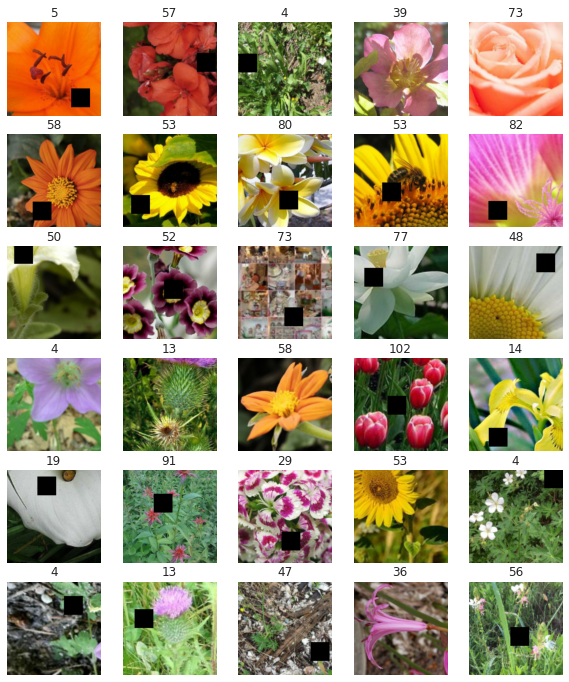

In [16]:
train_set    = Trainset()
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
valid_loader = DataLoader(Evalset(frac = 0.20), batch_size = 1, num_workers = 2)
test_loader  = DataLoader(Evalset(test = True), batch_size = 1, num_workers = 2)

# Display some training images and labels:
# ----------------------------------------
display_images(train_set, n = 30, cols = 5)

In [17]:
#learnable_modules = ('features.5.2', 'features.6', 'features.7', 'features.8', 'classifier')
learnable_modules = ('features.4.2','features.5','features.6', 'features.7', 'features.8', 'classifier')

# Model Initialization
model = nn.DataParallel(EfficientNetb0(n_classes=n_classes, learnable_modules=learnable_modules))

# # Load previous checkpoints
# model_path = f'/home/msai/suresh011/AI6102/model/Run7e_epoch29.pth'
# model.load_state_dict(torch.load(model_path))

model.to(device)

# Optimizer Setup
param_groups = [
    {'params': model.module.efficientnet_b0.features[4][2].parameters()},
    {'params': model.module.efficientnet_b0.features[5].parameters()},
    {'params': model.module.efficientnet_b0.features[6].parameters()},
    {'params': model.module.efficientnet_b0.features[7].parameters()},
    {'params': model.module.efficientnet_b0.features[8].parameters()},
    {'params': model.module.efficientnet_b0.classifier.parameters(), 'lr': classifier_lr}
]
optimizer = torch.optim.Adam(params=param_groups, lr=base_lr, weight_decay=weight_decay)

# Scheduler Setup
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

# Loss Function
loss_fn = F.nll_loss

# Log the initial learning rate
print(f"Initial learning rate: {base_lr}, Classifier learning rate: {classifier_lr}")


Initial learning rate: 0.0003, Classifier learning rate: 0.003


/home/msai/suresh011/.conda/envs/my_env38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/msai/suresh011/.conda/envs/my_env38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
import torch
from sklearn.metrics import f1_score
import time

losses = []
valid_f1s = []
valid_losses = []
max_f1 = 0

# Initialize a file to store training and validation losses and accuracies
log_filename = f'{name}_Train_loss_F1_score.txt'
with open(log_filename, 'a') as log_file:
    log_file.write(f'\n{name}-{comments} \n')
    log_file.write(f'--------------- \n')

epoch_start_time = time.time()

for epoch in range(n_epochs):
    print(f"\n{name}: Epoch {epoch + 1}/{n_epochs}")
    print('-' * 20)
    with open(log_filename, 'a') as log_file:
        log_file.write(f'\n{name} Epoch {epoch + 1}/{n_epochs} \n')
        log_file.write(f'--------------- \n')

    # Training phase
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)  # Move inputs to the appropriate device

        # Apply mixup
        x, targets_a, targets_b, lam = mixup_data(x, y, alpha=alpha, use_cuda=True)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(x)  # Forward pass
        loss_a = loss_fn(outputs, targets_a)
        loss_b = loss_fn(outputs, targets_b)
        loss = lam * loss_a + (1 - lam) * loss_b  # Combined loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item() * x.size(0)  # Update running loss

        if i % print_freq == 0:
            print(f"Batch {i}, Loss: {loss.item():.4f}")
            with open(log_filename, 'a') as log_file:
                log_file.write(f'Batch {i}, Loss: {loss.item():.4f} \n')
            

    epoch_loss = running_loss / len(train_loader.dataset)  # Calculate average loss for the epoch
    losses.append(epoch_loss)
    print(f"Training Loss: {epoch_loss:.4f}")
    # Log the losses
    with open(log_filename, 'a') as log_file:
        log_file.write(f'Training Loss: {epoch_loss:.4f} \n')

    # Validation phase
    if epoch % check_freq == 0:
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0

        valid_true_labs = []
        valid_pred_labs = []
        
        with torch.no_grad():  # Disables gradient calculation
            for x, y in valid_loader:
                # Assuming the extra dimensions are not needed, and you want to use one of the "sub-batches"
                # Adjust the slicing based on which part of the data you need
                x_corrected = x[:, 0, 0, :, :, :]  # This takes the first "sub-batch" and removes extra dimensions
                x_corrected = x_corrected.to(device)
                y = y.to(device)

                # Now x_corrected should have the shape [1, 3, 300, 300] or similar (adjust based on your needs)
                outputs = model(x_corrected)
                loss = loss_fn(outputs, y)
                running_val_loss += loss.item() * x.size(0)
                
                preds = torch.argmax(outputs, dim=1)
                valid_true_labs.extend(y.tolist())
                valid_pred_labs.extend(preds.tolist())

        epoch_val_loss = running_val_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_val_loss)
        valid_f1 = f1_score(valid_true_labs, valid_pred_labs, average='weighted')
        valid_f1s.append(valid_f1)
        print(f"Validation F1: {valid_f1 * 100:.2f}%, Validation Loss: {epoch_val_loss:.4f}")
        with open(log_filename, 'a') as log_file:
            log_file.write(f'Validation F1: {valid_f1 * 100:.2f}% \n')
            log_file.write(f'Validation Loss: {epoch_val_loss:.4f} \n')

        # # Save model checkpoint
        # torch.save(model.state_dict(), f'./model/{name}_epoch{epoch // check_freq}.pth')

        # Save model checkpoint
        if valid_f1 > max_f1:
            max_f1 = valid_f1
            if epoch % check_freq == 0:
                torch.save({
                    'epoch': n_epochs,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    # 'rng_state': torch.get_rng_state(),
                    # 'cuda_rng_state': torch.cuda.get_rng_state(),
                    # 'numpy_rng_state': np.random.get_state(),
                    # 'random_rng_state': random.getstate(),
                }, f'./model/{name}_epoch.pth')

    # Adjust learning rate
    scheduler.step()

epoch_end_time = time.time()
epoch_duration = epoch_end_time - epoch_start_time
total_duration = epoch_duration / 60  # Convert to minutes
with open(log_filename, 'a') as log_file:
    log_file.write(f'Total duration: {total_duration} minutes \n')


Run9c-100: Epoch 1/100
--------------------
Batch 0, Loss: 4.6393
Batch 64, Loss: 3.3832
Batch 128, Loss: 2.9721
Batch 192, Loss: 2.8689
Batch 256, Loss: 2.9037
Batch 320, Loss: 2.7548
Batch 384, Loss: 2.2772
Batch 448, Loss: 3.0697
Batch 512, Loss: 1.6160
Batch 576, Loss: 1.7751
Training Loss: 2.6581
Validation F1: 82.84%, Validation Loss: 0.7127

Run9c-100: Epoch 2/100
--------------------
Batch 0, Loss: 2.3037
Batch 64, Loss: 1.9442
Batch 128, Loss: 1.5256
Batch 192, Loss: 2.4823
Batch 256, Loss: 1.6819
Batch 320, Loss: 1.7495
Batch 384, Loss: 3.0872
Batch 448, Loss: 2.6109
Batch 512, Loss: 1.9223
Batch 576, Loss: 2.7430
Training Loss: 2.1750
Validation F1: 86.97%, Validation Loss: 0.5763

Run9c-100: Epoch 3/100
--------------------
Batch 0, Loss: 2.5897
Batch 64, Loss: 2.3605
Batch 128, Loss: 1.6463
Batch 192, Loss: 2.8471
Batch 256, Loss: 2.3445
Batch 320, Loss: 1.9307
Batch 384, Loss: 2.6441
Batch 448, Loss: 1.8193
Batch 512, Loss: 2.3933
Batch 576, Loss: 1.8849
Training Loss: 2

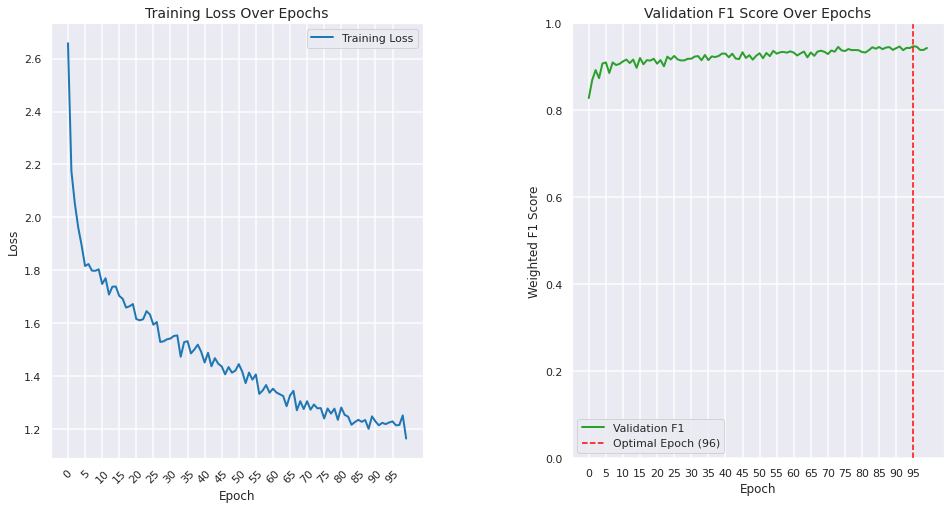

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Find the epoch with the highest F1 score
optimal_epoch = np.argmax(valid_f1s)

plt.figure(figsize=(16, 8))  # Increase figure size
plt.subplots_adjust(wspace=0.4)  # Adjust the space between plots

# Plot for Training Loss
plt.subplot(1, 2, 1)
plt.plot(losses, color='tab:blue', linewidth=2, label='Training Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14)
plt.xticks(np.arange(0, len(losses), 5), rotation=45)  # Adjust the frequency and rotate the labels
plt.grid(True, linestyle='-', linewidth=2, alpha=0.7)  # Stronger grid lines
plt.legend()

# Plot for Validation F1 Score
ax2 = plt.subplot(1, 2, 2)
ax2.plot(valid_f1s, color='tab:green', linewidth=2, label='Validation F1')
ax2.axvline(x=optimal_epoch, color='red', linestyle='dashed', label=f'Optimal Epoch ({optimal_epoch + 1})')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Weighted F1 Score', fontsize=12)
ax2.set_title('Validation F1 Score Over Epochs', fontsize=14)
ax2.set_ylim(0, 1)
ax2.set_xticks(np.arange(0, len(valid_f1s), 5))  # Adjust the frequency of x-ticks
ax2.grid(True, linestyle='-', linewidth=2, alpha=0.7)  # Stronger grid lines
ax2.legend()

# Save and show the improved plot
plt.savefig(f'./plot/{name}_improved_plot.png')  # Adjust path as needed
plt.show()



In [20]:
# ids = []
# preds = []

# checkpoint = torch.load(f'./model/{name}_epoch.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device)
         
# model.eval()
# with torch.no_grad():
#     for x, y in test_loader:
#         ids.append(y[0])
#         mean_logp = model(x.view(-1, 3, 300, 300).to(device)).mean(dim = 0)
#         preds.append(torch.argmax(mean_logp).item())
# submission = pd.DataFrame({'id': ids, 'label': preds})


In [21]:
# submission.to_csv(f'{name}_submission.csv', index = False)

In [22]:
# submission.head()

In [23]:
valid_f1_max = np.max(valid_f1s)
print(valid_f1_max)
with open(log_filename, 'a') as log_file:
    log_file.write(f'F1 max: {valid_f1_max * 100:.4f}%\n')

0.9477519143875949
